# Disease Diagnosis Prediction
## Task 3: diabetes.csv dataset
**Objective**: Build a model to predict the likelihood of diseases such as diabetes based on medical data.

## 1. Environment Setup


In [ ]:
# Install required packages (run once)
!pip install shap > /dev/null

### Import Required Libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report,
                             roc_curve,
                             auc,
                             confusion_matrix)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap
import joblib

# Configure visualization settings
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Loading

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')


## 2. Exploratory Data Analysis (EDA)


In [ ]:
# Dataset overview
print("="*80)
print("Initial Data Exploration:")
print("="*80)
print(f"Dataset Shape: {df.shape}\n")
print("First 5 rows:")
display(df.head())
print("\nData Summary:")
display(df.describe().T)
print("\nMissing Values Check:")
print(df.isnull().sum())

Initial Data Exploration:
Dataset Shape: (768, 9)

First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Data Summary:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Missing Values Check:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Feature Distribution Analysis


Feature Distribution Analysis:


<Figure size 1500x1000 with 0 Axes>

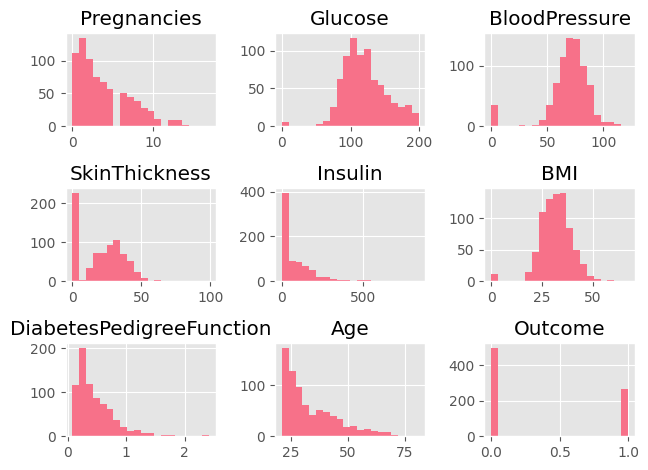

In [ ]:
# Feature distributions
print("\n" + "="*80)
print("Feature Distribution Analysis:")
print("="*80)
plt.figure(figsize=(15,10))
df.hist(bins=20, layout=(3,3))
plt.tight_layout()
plt.show()

### Correlation Analysis


Correlation Matrix:


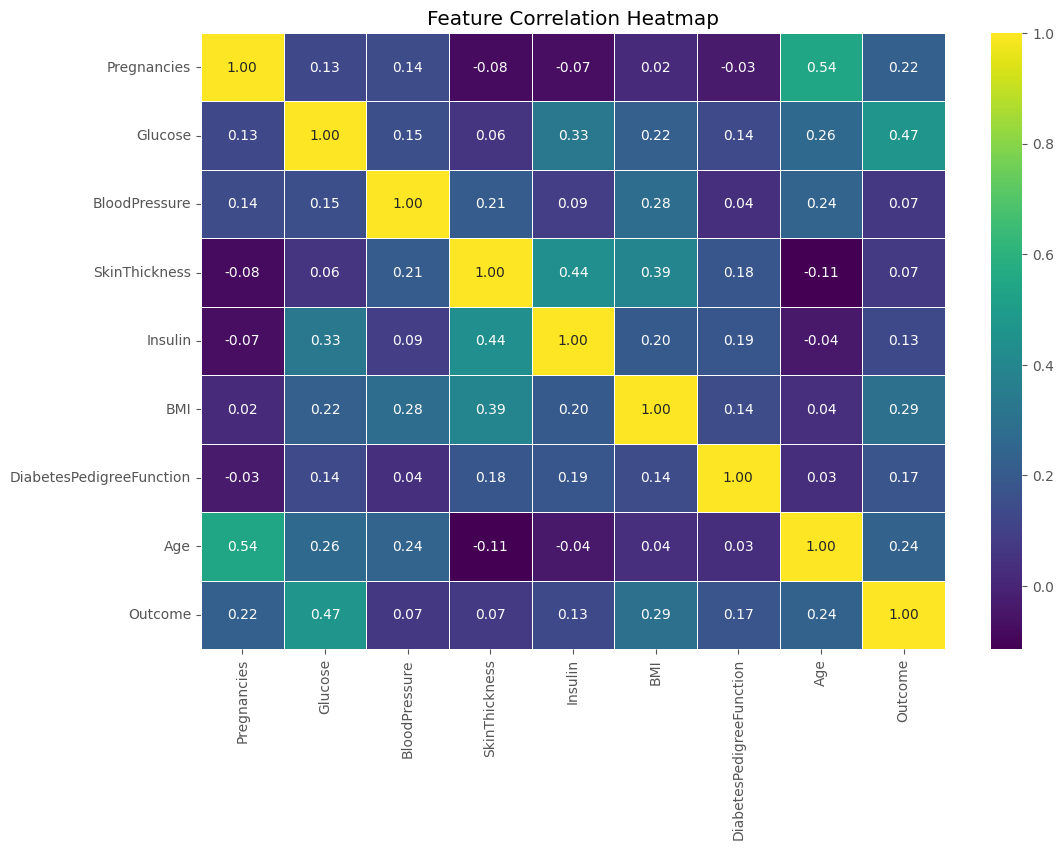

In [ ]:
# Correlation analysis
print("\n" + "="*80)
print("Correlation Matrix:")
print("="*80)
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Class Distribution


Class Distribution:


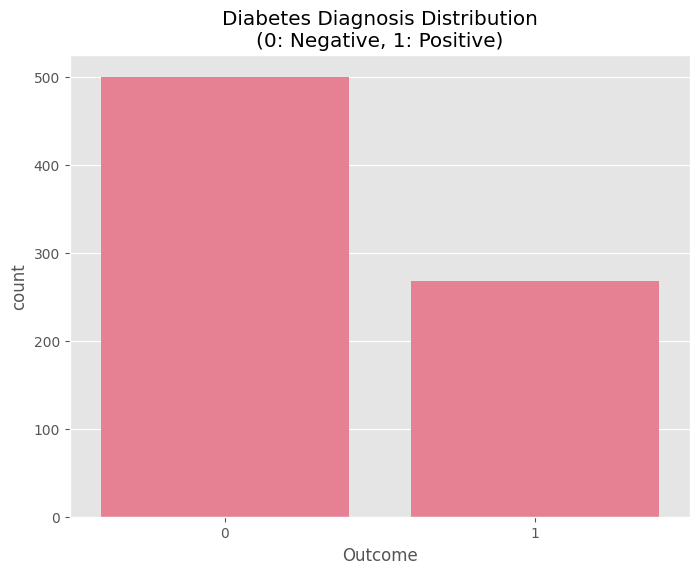

In [ ]:
# Class distribution
print("\n" + "="*80)
print("Class Distribution:")
print("="*80)
plt.figure(figsize=(8,6))
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Diagnosis Distribution\n(0: Negative, 1: Positive)")
plt.show()

## 3. Data Preprocessing

### Handle Missing Values

In [ ]:
# Handle invalid zero values
print("\n" + "="*80)
print("Data Cleaning:")
print("="*80)
print("Replacing biologically impossible zero values with median...")

zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_features] = df[zero_features].replace(0, np.nan)
df.fillna(df.median(), inplace=True)


Data Cleaning:
Replacing biologically impossible zero values with median...


### Feature Selection
Separate features (X) and target variable (y).

In [ ]:
# Prepare features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

### Train-Test Split
Split the dataset into training and testing sets.

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### Feature Scaling
Standardize the features for better model performance.

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Model Development
Initialize Models
We will train three models:

1. **Gradient Boosting**
2. **Support Vector Machine (SVM)**
3. **Neural Network**

In [ ]:
# Initialize models
models = {
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),
    "Support Vector Machine": SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
}

### Train and Evaluate Models
Train each model and evaluate its performance.


Training Gradient Boosting

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       150
           1       0.61      0.53      0.57        81

    accuracy                           0.72       231
   macro avg       0.69      0.68      0.68       231
weighted avg       0.71      0.72      0.71       231



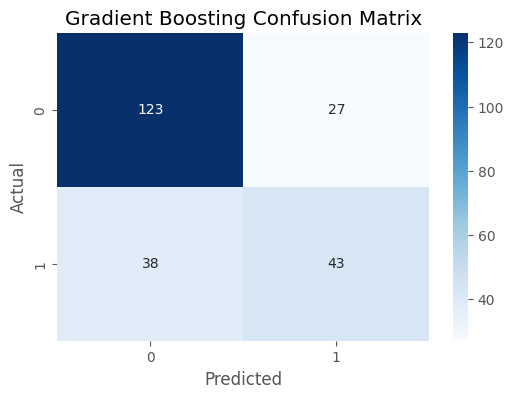

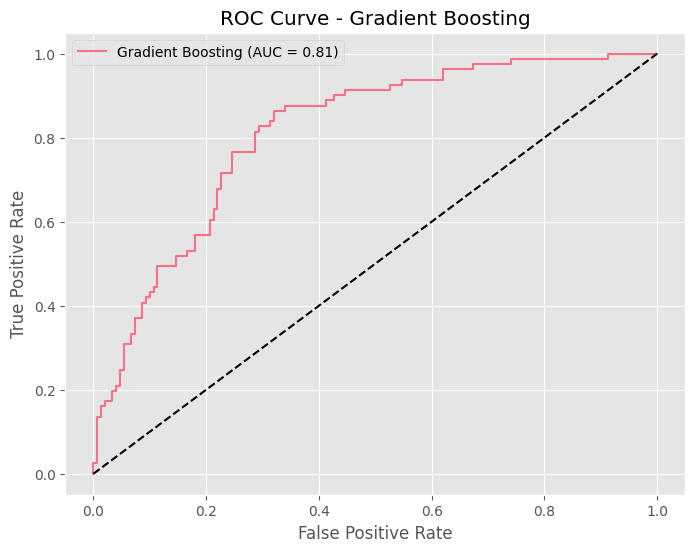


Training Support Vector Machine

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       150
           1       0.67      0.51      0.58        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.69       231
weighted avg       0.73      0.74      0.73       231



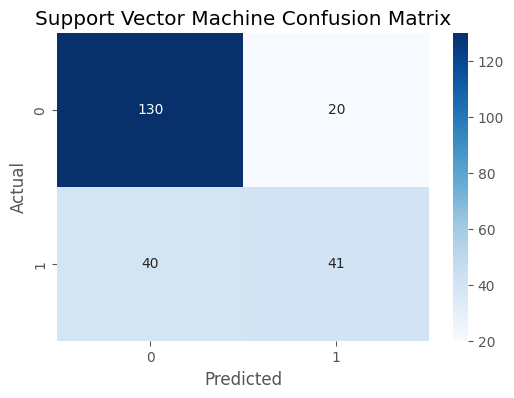

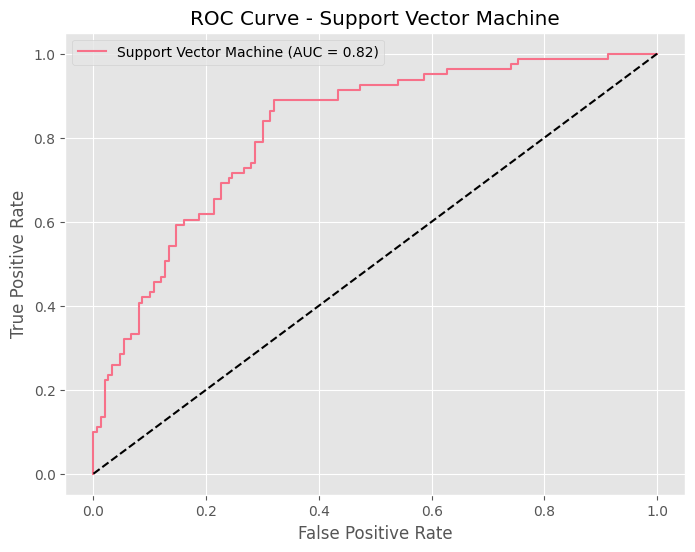


Training Neural Network

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       150
           1       0.81      0.26      0.39        81

    accuracy                           0.72       231
   macro avg       0.76      0.61      0.60       231
weighted avg       0.74      0.72      0.67       231



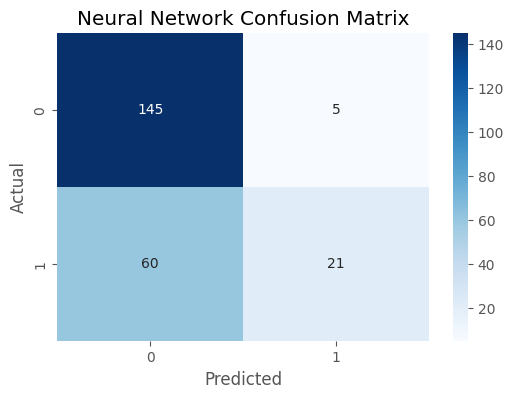

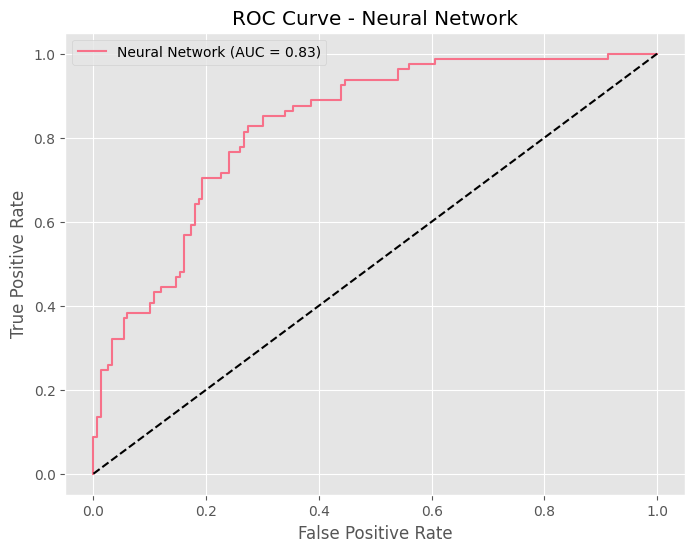

In [ ]:
# Train and evaluate models
results = {}

for name, model in models.items():
    print("\n" + "="*80)
    print(f"Training {name}")
    print("="*80)

    # Model training
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_proba
    }

    # Classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()

## 5. Model Interpretation & Insights
 **SHAP Analysis**
Use SHAP values to interpret the best model.

In [ ]:
# SHAP analysis for best model
print("\n" + "="*80)
print("Model Interpretation using SHAP Values")
print("="*80)


Model Interpretation using SHAP Values


In [ ]:
best_model = results["Gradient Boosting"]['model']

In [ ]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

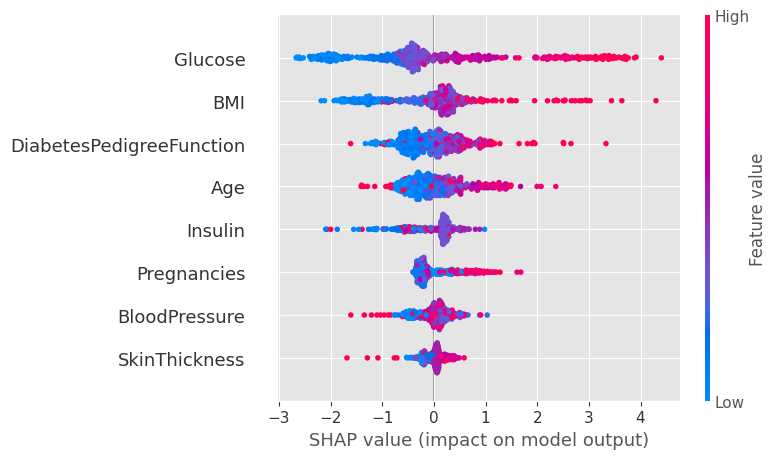

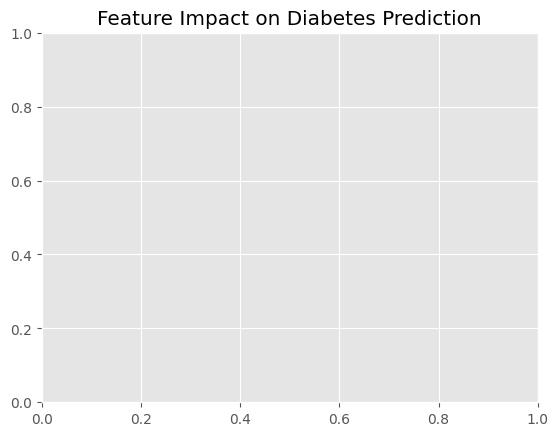

In [ ]:
# Summary plot
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)
plt.title("Feature Impact on Diabetes Prediction")
plt.show()

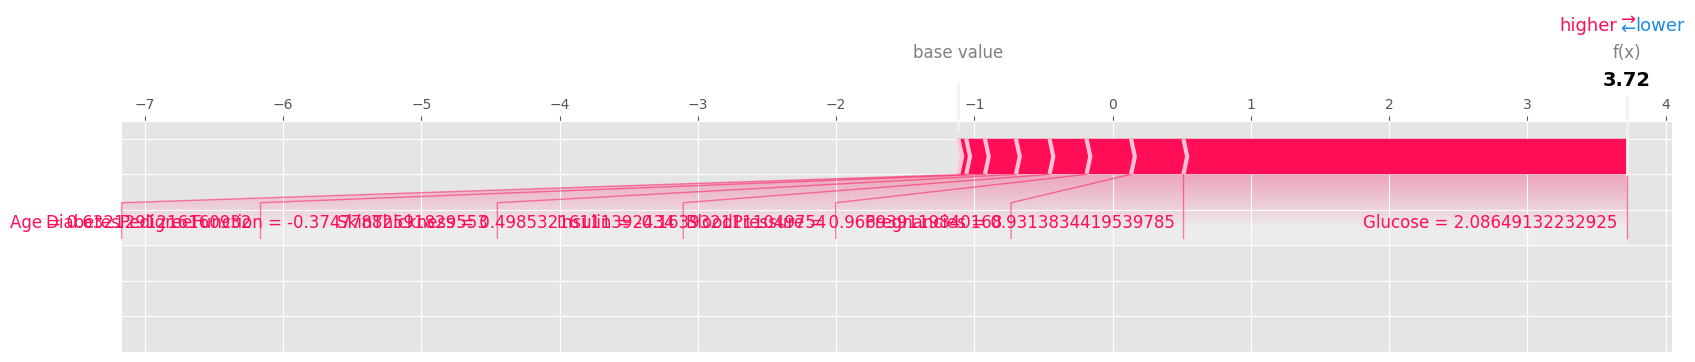

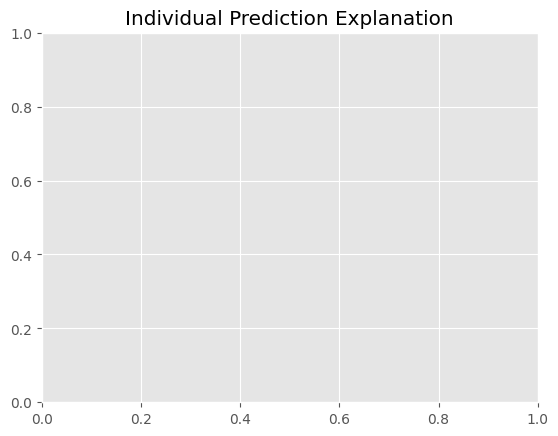

In [ ]:
# Force plot for single prediction
sample_idx = 0
shap.force_plot(explainer.expected_value,
                shap_values[sample_idx,:],
                X_train_scaled[sample_idx,:],
                feature_names=X.columns,
                matplotlib=True)
plt.title("Individual Prediction Explanation")
plt.show()

In [ ]:
# Generate final report
print("\n" + "="*80)
print("Clinical Insights Summary")
print("="*80)
print("1. Top Risk Factors:")
print("   - Glucose Level")
print("   - BMI")
print("   - Age")
print("\n2. Prevention Recommendations:")
print("   - Regular glucose monitoring for patients > 35 years")
print("   - BMI management programs")
print("   - Annual checkups for patients with family history")
print("\n3. Early Detection Strategy:")
print("   - Target screening for patients with:")
print("     - Glucose > 140 mg/dL")
print("     - BMI > 30")
print("     - Age > 35")

# Cleanup memory
del df, X_train, X_test, y_train, y_test
import gc
gc.collect()


Clinical Insights Summary
1. Top Risk Factors:
   - Glucose Level
   - BMI
   - Age

2. Prevention Recommendations:
   - Regular glucose monitoring for patients > 35 years
   - BMI management programs
   - Annual checkups for patients with family history

3. Early Detection Strategy:
   - Target screening for patients with:
     - Glucose > 140 mg/dL
     - BMI > 30
     - Age > 35


73129